## Transformer구조 구현

In [ ]:
# !pip install sentencepiece

In [ ]:
# pip install pytorch

#### 1. 데이터 확인

In [ ]:
# data를 저장할 directory 확인
data_dir = "./자연어 처리/day2/day2/data"

#### 2. Imports

In [ ]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

#### 3. 폴더의 목록을 확인
data_dir 목록을 확인 합니다.

In [ ]:
for f in os.listdir(data_dir):
  print(f)

kowiki.model
kowiki.vocab
kowiki.txt


#### 4. Vocab 및 입력
Sentencepiece를 활용해 미리 만든 voca를 로드함  
: wiki corpus로 만들어 놓음

로딩된 vocab을 이용해 input을 만듭니다.

# vocab 만들기
- 1. lines = [] # input 문장 2개 작성
- 2. kowiki.model load 하기
- 3. encoding하기
- 4. inputs = [] # encoding to idx


In [ ]:
# vocab 로딩

# SentencePieceProcessor를 사용하여 한국어 단어 집합(vocabulary)을 로드합니다.
# 이전에 학습된 모델 파일의 경로를 지정합니다.
vocab_file = './자연어 처리/day2/day2/data/kowiki.model'

# SentencePieceProcessor 객체를 생성합니다.
vocab = spm.SentencePieceProcessor()

# 이전에 학습된 모델 파일을 로드합니다.
vocab.load(vocab_file)

True

In [ ]:
# 문장 작성
lines = [
    "여름은 더워요.",
    "감기 조심하세요."
]

# encoding : encode_as_ids
# 문장을 토큰화하고 인코딩하여 단어를 정수 인덱스로 변환합니다.
inputs = []
for line in lines:
  # SentencePiece를 사용하여 문장을 서브워드로 토큰화합니다.
  pieces = vocab.encode_as_pieces(line)
  # SentencePiece를 사용하여 문장을 정수 인덱스로 인코딩합니다.
  ids = vocab.encode_as_ids(line) # ids 단위  # 단어를 정수 인덱스로 변환합니다.
  inputs.append(torch.tensor(ids))
  # 토큰화된 서브워드와 정수 인코딩된 단어를 출력합니다.
  print(pieces)
  print(ids)

# 입력 길이에 대해 padding
# 패딩을 수행하기 위해 리스트로 된 토큰화된 문장들을 텐서로 변환합니다.
inputs =torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)

# input 확인
print(inputs.size())
print(inputs)

['▁여름', '은', '▁더', '워', '요', '.']
[2395, 3744, 211, 4081, 3902, 3730]
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
[199, 3746, 54, 3974, 3736, 3826, 3902, 3730]
torch.Size([2, 8])
tensor([[2395, 3744,  211, 4081, 3902, 3730,    0,    0],
        [ 199, 3746,   54, 3974, 3736, 3826, 3902, 3730]])


https://techblog-history-younghunjo1.tistory.com/497

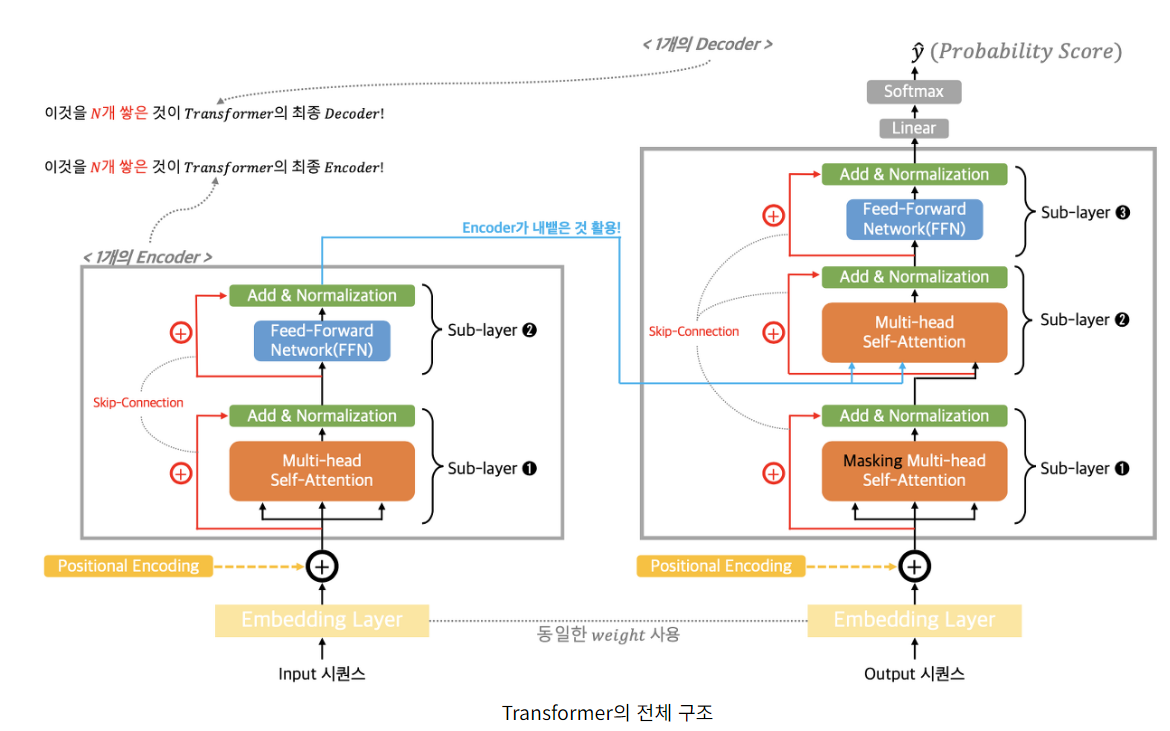

# 트랜스포머 과정
1. Input Embedding: input에 입력된 데이터를 컴퓨터가 이해할 수 있도록 행렬 값으로 바꾸어줌. ex) 문장을 구성하는 각각의 단어는 그에 상응하는 인덱스 값에 매칭이 되고, 이 인덱스 값들이 Input Embedding에 전달됨. --> 단어의 위치(순서)를 알 수 없다는 문제 발생 --> Positional Enncoding 실시
2. Position Embedding = Positional Encoding
- 1) 문장의 position 별 angle 값을 구하여 문장 내 각 위치에 대한 상대적 위치 정보를 모델에게 전달.
- 2) 짝수 index --> sin / 홀수 index --> cos
3. Scaled Dot Product Attention: Multi-Head Attention 실행 위해 먼저 구하기.
- 0) 입력값 = Q, K, V, attention mask로 구성되며 이 중 K=V여야 함.
- 0)
  - Q(Query): 입력 시퀀스에서 관련 부분을 찾으려고 하는 정보 벡터(소스). 연관된 정도를 표현하는 가중치 계산에 사용
  - K(Key): 관계의 연관도를 결정하기 휘애 query와 비교하는데 사용되는 벡터(타겟). 연관된 정도를 표현하는 가중치 계산에 사용.
  - V(value): 특정 Key에 해당하는 입력 시퀀스의 정보로 가중치를 구하는데 사용되는 벡터(벨류). 관계성 표현하는 가중치 합이 최종 출력을 계산하는데 사용.
- 1) MatMul(Q, K) -> Scale -> Mask(opt.) -> SoftMax -> MatMul(Q*K, V)
4. Multi-Head Attention: query, key, value를 헤드 수만큼 나누어 병렬적으로 계산해주는 것이 핵심
- 1) (그림 1,2,3과정) Multi Head Q, K, V: Q, K, V 모두 Multi Head로 나눔. Attention Mask도 Multi Head로 변경하여 Q, K, V linear통과 시킴. Linear Layer를 이용해서 Q, K, V의 차원을 감소하며 Query와 Key의 차원이 맞지 않을 경우 맞추는 역할.
- 2) (그림 4과정) Scaled Dot Product Attention을 사용하여 Multi Head에 대한 Attention 구함.
- 3) (그림 5과정) 헤드 연결(concat). Multi Head를 한개로 합침.
- 4) (그림 6과정) 마지막으로 선형층(linear)을 거쳐 나옴. Linear Layer는 attention value의 차원을 필요에 따라 변경. 입력 Q와 동일한 shape을 가진 Multi Head Attention이 구함.
5. Masked multi-head attention: 디코더(Decoder)에서의 Self-Attention Layer 는 반드시 자기 자신 보다 앞쪽에 포지션에 해당하는 토큰들의 어텐션 스코어만 볼수있다. 아웃풋들이 주어졌을 때 뒤에 나오는 단어들은 볼 수 없다. Decoder 부분에서 현재 내가 알고있는 정보까지만 self-Attention이 가능
- 1) pad mask, decoder mask 그리고 이 둘을 합한 attention mask를 확인
- 2) Multi-Head Attention과 동일하므로 위에서 선언한 MultiHeadAttention 클래스를 바로 호출하여 출력
6. Feed-forward Layer: 입력 신호를 받아서 선형 변환과 비선형 활성화 함수를 적용한 후 출력을 생성
- 1) f1 (Linear)
- 2) Ativation (relu or gelu)
- 3) f3 (Linear)


#### 5. Embedding

#### - Input Embedding

In [ ]:
# 단어 집합(vocabulary)의 크기를 확인합니다.
n_vocab = len(vocab)
print(n_vocab)

# 임베딩 차원의 크기를 설정합니다.
d_hidn=128

# nn.Embedding을 사용하여 단어 집합의 크기와 임베딩 차원을 가지는 임베딩 레이어를 생성합니다.
# 이 레이어는 단어의 정수 인덱스를 해당하는 임베딩 벡터로 변환합니다.
nn_emb = nn.Embedding(n_vocab, d_hidn)

# 임베딩 레이어를 사용하여 입력 토큰을 임베딩 벡터로 변환합니다.
# inputs는 이전 단계에서 패딩된 입력 텐서입니다.
input_embs = nn_emb(inputs)

# 변환된 임베딩 벡터의 크기를 출력합니다.
print(input_embs.size())

8007
torch.Size([2, 8, 128])


##### - Position Embedding = Positional Encoding

1. 문장의 position 별 angle 값을 구함  
2. 구해진 angle 중 짝수 index의 값에 대한 sin 값을 구합니다.  
3. 구해진 angle 중 홀수 index의 값에 대한 cos 값을 구합니다.

In [ ]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):

  # 각 position과 dimension에 따라 angle 값을 계산하는 함수입니다
  def cal_angle(position, i_hidn):
    return position / np.power(10000, 2*(i_hidn // 2) / d_hidn)

  # 각 position에 대해 angle 값을 계산하여 반환하는 함수입니다.
  def get_posi_angle_vec(position):
    return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

  # 각 position에 대해 dimension에 따라 angle 값을 구함
  # sinusoid 테이블을 초기화합니다. 크기는 (n_seq, d_hidn)입니다.
  sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])

  # 홀수 차원은 sin 값을, 짝수 차원은 cos 값을 적용합니다.
  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

  return sinusoid_table

In [ ]:
# 시퀀스 길이
n_seq=64

# 주어진 시퀀스 길이와 임베딩 차원을 이용하여 sinusoid 위치 임베딩 테이블을 생성합니다.
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)
# 생성된 테이블의 모양을 확인합니다.
pos_encoding.shape

# embedding 그림 출력
# plt.pcolormesh(pos_encoding, cmap='RdBu')
# plt.xlabel('Depth')
# plt.xlim((0, d_hidn))
# plt.ylabel('Position')
# plt.colorbar()
# plt.show()

(64, 128)

In [ ]:
# position embedding 구성
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)
print(inputs.size())

# position masking 하기 # +1 --> padding_value로 0사용하고 있으므로 1부터 나오게 하기 위해 +1
positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
print(positions)

pos_mask = inputs.eq(0)
print(pos_mask)
positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions)
print(positions)
print(pos_embs.size())

torch.Size([2, 8])
tensor([[1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8]])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


In [ ]:
# 초기 input 값 구성
input_sums = input_embs + pos_embs
print(input_sums.size())

torch.Size([2, 8, 128])


#### 6. Scale Dot Product Attention

##### Input

In [ ]:
# input 입력 값을 만드는 과정
Q = input_sums
K = input_sums
V = input_sums

# attention에 대한 masking 구성
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


##### Q * K-transpose

In [ ]:
# Q * K 내적
# q.size=(2,8,128)
# k.size=(2,8,128)
scores = torch.matmul(Q, K.transpose(-1,-2))
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[183.3846,  55.2058,  51.9440,  51.5709,  21.4212,  47.5668,  65.8561,
          65.8561],
        [ 55.2058, 163.5424,  61.4374,  56.8916,  44.6765,  67.2638,  41.6427,
          41.6427],
        [ 51.9440,  61.4374, 184.3282,  62.9011,  54.0070,  57.9052,  36.5489,
          36.5489],
        [ 51.5709,  56.8916,  62.9011, 203.0904,  48.2760,  71.0749,  40.6602,
          40.6602],
        [ 21.4212,  44.6765,  54.0070,  48.2760, 196.6880,  73.7292,  23.9353,
          23.9353],
        [ 47.5668,  67.2638,  57.9052,  71.0749,  73.7292, 204.9986,  25.0625,
          25.0625],
        [ 65.8561,  41.6427,  36.5489,  40.6602,  23.9353,  25.0625, 181.6661,
         181.6661],
        [ 65.8561,  41.6427,  36.5489,  40.6602,  23.9353,  25.0625, 181.6661,
         181.6661]], grad_fn=<SelectBackward0>)


##### Scale

In [ ]:
# scaled dot

#d_head --> 헤드 별 히든 사이즈
d_head = 64  # N_head : 2로 지정되어 있는 상태
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[22.9231,  6.9007,  6.4930,  6.4464,  2.6777,  5.9459,  8.2320,  8.2320],
        [ 6.9007, 20.4428,  7.6797,  7.1114,  5.5846,  8.4080,  5.2053,  5.2053],
        [ 6.4930,  7.6797, 23.0410,  7.8626,  6.7509,  7.2382,  4.5686,  4.5686],
        [ 6.4464,  7.1114,  7.8626, 25.3863,  6.0345,  8.8844,  5.0825,  5.0825],
        [ 2.6777,  5.5846,  6.7509,  6.0345, 24.5860,  9.2161,  2.9919,  2.9919],
        [ 5.9459,  8.4080,  7.2382,  8.8844,  9.2161, 25.6248,  3.1328,  3.1328],
        [ 8.2320,  5.2053,  4.5686,  5.0825,  2.9919,  3.1328, 22.7083, 22.7083],
        [ 8.2320,  5.2053,  4.5686,  5.0825,  2.9919,  3.1328, 22.7083, 22.7083]],
       grad_fn=<SelectBackward0>)


##### Mask (Opt.)

In [ ]:
# masking
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[ 2.2923e+01,  6.9007e+00,  6.4930e+00,  6.4464e+00,  2.6777e+00,
          5.9459e+00, -1.0000e+09, -1.0000e+09],
        [ 6.9007e+00,  2.0443e+01,  7.6797e+00,  7.1114e+00,  5.5846e+00,
          8.4080e+00, -1.0000e+09, -1.0000e+09],
        [ 6.4930e+00,  7.6797e+00,  2.3041e+01,  7.8626e+00,  6.7509e+00,
          7.2382e+00, -1.0000e+09, -1.0000e+09],
        [ 6.4464e+00,  7.1114e+00,  7.8626e+00,  2.5386e+01,  6.0345e+00,
          8.8844e+00, -1.0000e+09, -1.0000e+09],
        [ 2.6777e+00,  5.5846e+00,  6.7509e+00,  6.0345e+00,  2.4586e+01,
          9.2161e+00, -1.0000e+09, -1.0000e+09],
        [ 5.9459e+00,  8.4080e+00,  7.2382e+00,  8.8844e+00,  9.2161e+00,
          2.5625e+01, -1.0000e+09, -1.0000e+09],
        [ 8.2320e+00,  5.2053e+00,  4.5686e+00,  5.0825e+00,  2.9919e+00,
          3.1328e+00, -1.0000e+09, -1.0000e+09],
        [ 8.2320e+00,  5.2053e+00,  4.5686e+00,  5.0825e+00,  2.9919e+00,
          3.1328e+00, -1.0000e+09, -1.0000e

##### Softmax

In [ ]:
# softmax 적용
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 8, 8])
tensor([[1.0000e+00, 1.1005e-07, 7.3200e-08, 6.9864e-08, 1.6126e-09, 4.2353e-08,
         0.0000e+00, 0.0000e+00],
        [1.3145e-06, 9.9999e-01, 2.8644e-06, 1.6228e-06, 3.5248e-07, 5.9338e-06,
         0.0000e+00, 0.0000e+00],
        [6.5055e-08, 2.1313e-07, 1.0000e+00, 2.5592e-07, 8.4193e-08, 1.3706e-07,
         0.0000e+00, 0.0000e+00],
        [5.9496e-09, 1.1570e-08, 2.4523e-08, 1.0000e+00, 3.9411e-09, 6.8124e-08,
         0.0000e+00, 0.0000e+00],
        [3.0572e-10, 5.5947e-09, 1.7960e-08, 8.7737e-09, 1.0000e+00, 2.1133e-07,
         0.0000e+00, 0.0000e+00],
        [2.8414e-09, 3.3329e-08, 1.0346e-08, 5.3667e-08, 7.4783e-08, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.8621e-01, 4.2961e-02, 2.2727e-02, 3.7996e-02, 4.6967e-03, 5.4073e-03,
         0.0000e+00, 0.0000e+00],
        [8.8621e-01, 4.2961e-02, 2.2727e-02, 3.7996e-02, 4.6967e-03, 5.4073e-03,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward0>)


##### atten_prov * V

In [ ]:
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 8, 128])


##### Implementation Class

In [ ]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        """
        스케일된 닷 프로덕트 어텐션의 파이토치 구현 클래스입니다.

        Args:
            d_head (int): 어텐션 헤드의 차원 수
        """

        # 스케일 계산을 위한 값 설정
        self.scale = 1 / (d_head ** 0.5)

    def forward(self, Q, K, V, attn_mask):
        """
        어텐션의 forward pass를 수행합니다.

        Args:
            Q (torch.Tensor): 쿼리(Query) 텐서
            K (torch.Tensor): 키(Key) 텐서
            V (torch.Tensor): 값(Value) 텐서
            attn_mask (torch.Tensor, optional): 어텐션 마스크 (패딩 마스크 등), 기본값은 None

        Returns:
            context (torch.Tensor): 어텐션 가중합 결과
            attn_prob (torch.Tensor): 어텐션 가중치
        """
        # 어텐션 스코어 계산: Q와 K의 닷 프로덕트
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)

        # 마스크 적용: 선택적으로 패딩 마스크나 미래 정보 마스크를 적용합니다.
        scores.masked_fill_(attn_mask, -1e9)

        # 소프트맥스 함수를 적용하여 어텐션 가중치를 계산합니다.
        attn_prob = torch.nn.functional.softmax(scores, dim=-1)

        # 가중합 계산: 어텐션 가중치와 값 텐서를 곱하고 합하여 어텐션 결과를 계산
        context = torch.matmul(attn_prob,V)

        return context, attn_prob

#### 7. Multi-Head Attention

##### Input

In [ ]:
Q = input_sums
K = input_sums
V = input_sums

# masking 만들기
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

batch_size = Q.size(0)
n_head = 2

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


##### Multi Head Q, K, V

In [ ]:
# 멀티 헤드 수에 맞게 linear 구성
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

In [ ]:
# 멀티 헤드 수에 맞게 변경 -> Q, K, V 모두

# q_s

# 멀티 헤드 어텐션을 위한 Q(Query)에 대한 가중치 행렬을 적용합니다.
# 이 가중치 행렬은 학습 가능한 파라미터인 W_Q에 입력 데이터 Q를 곱하여 얻습니다.
q_s = W_Q(Q)
print(q_s.size())

# 멀티 헤드 어텐션을 위해 Q 텐서를 적절한 형태로 변환합니다.
# 이를 위해 먼저 Q 텐서의 모양을 (배치 크기, 시퀀스 길이, 헤드 수, 헤드 당 차원)으로 조정합니다.
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())

# 헤드의 차원과 시퀀스의 길이를 교환하여 헤드 간에 정보를 교환합니다.
# 이를 위해 transpose를 사용하여 첫 번째와 두 번째 차원을 교환합니다.
# 따라서 텐서의 모양이 (배치 크기, 헤드 수, 시퀀스 길이, 헤드 당 차원)이 됩니다.
q_s = q_s.transpose(1, 2)
print(q_s.size())

# 한줄로 정리
# W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1, 2)

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


In [ ]:
# k_s

# 주어진 입력 데이터 K에 대한 가중치 행렬을 적용합니다.
# 학습 가능한 파라미터인 W_K에 입력 데이터 K를 곱하여 얻습니다.
k_s = W_K(K)
print(k_s.size())

# 멀티 헤드 어텐션을 위해 K 텐서를 적절한 형태로 변환합니다.
# 이를 위해 K 텐서의 모양을 (배치 크기, 시퀀스 길이, 헤드 수, 헤드 당 차원)으로 조정합니다.
k_s = k_s.view(batch_size,  -1, n_head, d_head)
print(k_s.size())

# 헤드의 차원과 시퀀스의 길이를 교환하여 헤드 간에 정보를 교환합니다.
# 이를 위해 transpose를 사용하여 첫 번째와 두 번째 차원을 교환합니다.
# 따라서 텐서의 모양이 (배치 크기, 헤드 수, 시퀀스 길이, 헤드 당 차원)이 됩니다.
k_s = k_s.transpose(1, 2)
print(k_s.size())

# 한줄로 정리
# k_s(K).view(batch_size, -1, n_head, d_head).transpose(1, 2)

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


In [ ]:
# v_s

# 주어진 입력 데이터 K에 대한 가중치 행렬을 적용합니다.
# 학습 가능한 파라미터인 W_V에 입력 데이터 V를 곱하여 얻습니다.
v_s = W_V(V)
print(v_s.size())

# 멀티 헤드 어텐션을 위해 V 텐서를 적절한 형태로 변환합니다.
# 이를 위해 V 텐서의 모양을 (배치 크기, 시퀀스 길이, 헤드 수, 헤드 당 차원)으로 조정합니다.
v_s = v_s.view(batch_size,  -1, n_head, d_head)
print(v_s.size())

# 헤드의 차원과 시퀀스의 길이를 교환하여 헤드 간에 정보를 교환합니다.
# 이를 위해 transpose를 사용하여 첫 번째와 두 번째 차원을 교환합니다.
# 따라서 텐서의 모양이 (배치 크기, 헤드 수, 시퀀스 길이, 헤드 당 차원)이 됩니다.
v_s = v_s.transpose(1, 2)
print(v_s.size())

# 한줄로 정리
# v_s(K).view(batch_size, -1, n_head, d_head).transpose(1, 2)

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


In [ ]:
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


##### Multi Head Attention Mask

In [ ]:
# Mask도 변경 (2,2,8,8)
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


##### Attention

In [ ]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


##### Concat

In [ ]:
# 목표 --> [2,8,128]

# context를 transpose하여 차원을 변경하고, contiguous() 함수를 사용하여 연속적인 메모리 공간을 확보합니다.
# 그리고 view 함수를 사용하여 원하는 크기의 텐서로 변환합니다.
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head *d_head)
context.size()

torch.Size([2, 8, 128])

##### Linear

In [ ]:
# output --> d_hidn
linear = nn.Linear(n_head * d_head, d_hidn) # aw+b
output = linear(context)
output.size()

torch.Size([2, 8, 128])

##### Implementation Class

In [ ]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        # self 인자
        self.d_hidn = d_hidn # 은닉 차원
        self.n_head = n_head # 어텐션 헤드 수
        self.d_head = d_head # 각 어텐션 헤드의 차원

        # input Q, K, V linear / sacled_dot_attn / linear
        # 입력 Q, K, V에 대한 선형 변환을 위한 가중치 행렬 선언
        self.W_Q = nn.Linear(d_hidn, n_head * d_head) # Query에 대한 선형 레이어
        self.W_K = nn.Linear(d_hidn, n_head * d_head) # Key에 대한 선형 레이어
        self.W_V = nn.Linear(d_hidn, n_head * d_head) # Value에 대한 선형 레이어
        # 스케일드 닷 프로덕트 어텐션 선언
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        # 출력에 대한 선형 변환을 위한 가중치 행렬 선언
        self.linear = nn.Linear(n_head * d_head, d_hidn)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # Q, K, V에 대한 선형 변환 후 텐서의 형태 변환
        # q_s: (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        # k_s: (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        # v_s: (bs, n_head, n_v_seq, d_head)
        k_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)

        # mask  # 어텐션 마스크 선언 및 적용
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask .unsqueeze(1).repeat(1, self.n_head, 1, 1)  # 어텐션 마스크 반복 적용 -> 반복 = 1

        # scaled dot  # 스케일드 닷 프로덕트 어텐션 수행
        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)

        # concat  # 각 어텐션 헤드 결과를 연결(concatenate)
        # (bs, n_q_seq, h_head * d_head)
        context = context.transpose(1,2).contiguous().view(batch_size, -1, self.n_head * self.d_head)

        # linear  # 출력에 대한 선형 변환 수행
        # (bs, n_q_seq, d_hidn)
        output = self.linear(context)

        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        # 출력 텐서와 어텐션 가중치 반환
        return output, attn_prob

#### 8. Masked Multi Head Attention

In [ ]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
  subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
  subsequent_mask = subsequent_mask.triu(diagonal=1)
  return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

# attn_pad_mask : 기존 input에 대한 pad mask
attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[0])

# attn_dec_mask : 현재 단어에서 이전 단어만 보겠다는 attention mask
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[0])

# attn_mask = attn_pad_mask + attn_dec_mask
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[0])

# attn_mask : attn_pad_mask
batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],


In [ ]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


#### 9. Feed Forward

##### f1 (Linear)

In [ ]:
# Linear : Conv1d로 활용
# (bs, d_hidn * 4, n_seq) -> (ns, d_hidn * 4, n_seq)
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn*4, kernel_size=1)
print(conv1)

ff_1 = conv1(output.transpose(1,2))
print(ff_1.size())

Conv1d(128, 512, kernel_size=(1,), stride=(1,))
torch.Size([2, 512, 8])


##### Activation (relu or gelu)

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/activation.png)

In [ ]:
active = F.gelu
ff_2 = active(ff_1)

##### f3 (Linear)

In [ ]:
# Linear : Conv1d로 활용
# (ns, d_hidn * 4, n_seq) -> (bs, d_hidn * 4, n_seq)
conv2 = nn.Conv1d(in_channels=d_hidn*4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1,2)
print(ff_3.size())

torch.Size([2, 8, 128])


##### Implementation Class

In [ ]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()
        self.d_hidn = d_hidn
        self.conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn*4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_hidn*4, out_channels=d_hidn, kernel_size=1)
        self.active = F.gelu()

    def forward(self, inputs):
        # f1 output: (bs, d_ff, n_seq)
        output = self.activ(self.conv1(inputs.transpose(1,2)))

        # f2 output: (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1,2)

        # (bs, n_seq, d_hidn)
        return output